# **Ridge Regularization**

In [29]:
import numpy as np

import matplotlib.pyplot as plt
import plotly.graph_objects as go

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.datasets import load_diabetes
from sklearn.linear_model import Ridge
from sklearn.metrics import r2_score

# **Ridge Regularization on 2D data using OLS**

## Creating Linear Datapoints

In [30]:
np.random.seed(42)
X = 2 + np.random.randn(100, 1)
y = (1.14 * X) + 25 + np.random.randn(100, 1)

## Creating Ridge Regularization class

In [31]:
class RidgeRegularization:
    def __init__(self, alpha = 0.01) -> None:
        self.coef_ = None
        self.intercept_ = None
        self.alpha = alpha

    def fit(self, X_train, y_train) -> None:
        X_train = np.array(X_train).ravel()
        y_train = np.array(y_train).ravel()
        
        numerator = np.sum((y_train - y_train.mean()) * (X_train - X_train.mean()))
        denominator = np.sum((X_train - X_train.mean())**2) + self.alpha

        self.coef_ = numerator / denominator
        self.intercept_ = y_train.mean() - self.coef_ * X_train.mean()
    
    def predict(self, X_test):
        return np.dot(X_test, self.coef_,) + self.intercept_

## Comparison of Best Fit Line for various values of alpha

R2 Score for alpha = 0 is  0.47863499485322314
R2 Score for alpha = 10 is  0.472937046930742
R2 Score for alpha = 100 is  0.3335832253098642
R2 Score for alpha = 1000 is  0.06953529876432207


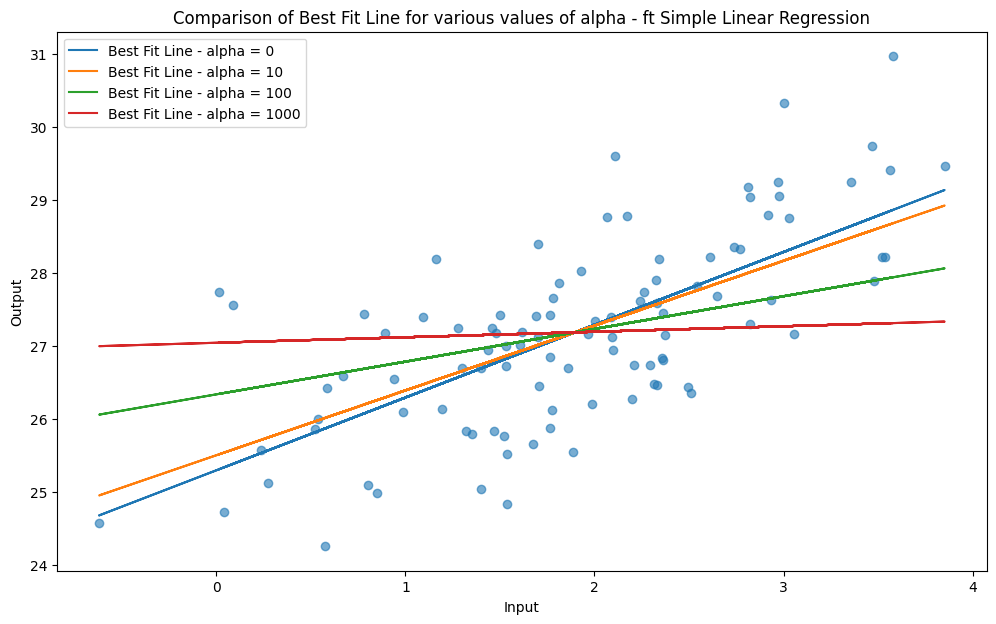

In [32]:
alphas = [0, 10, 100, 1000]

plt.figure(figsize=(12,7))
plt.scatter(X, y, alpha=0.6)

for alpha in alphas:
    model = RidgeRegularization(alpha=alpha)
    model.fit(X, y)

    y_pred = model.predict(X)
    print(f'R2 Score for alpha = {alpha} is ', r2_score(y, y_pred))

    plt.plot(X, y_pred, label=f'Best Fit Line - alpha = {alpha}')

plt.title("Comparison of Best Fit Line for various values of alpha - ft Simple Linear Regression")

plt.xlabel('Input')
plt.ylabel('Output')

plt.legend()
plt.show()

## Observations:
- The Addition of l2-norm Term forces the learning algorithm not only fit the data but also keep the model weight as small as possible.

- Higher alpha : Underfitting

- Lower alpha : Overfitting

# **Ridge Regularization on nD data using OLS**

In [33]:
X, y = load_diabetes(return_X_y=True)
y = y.reshape(-1, 1)

In [34]:
class RidgeRegularizationMR:
    def __init__(self, alpha) -> None:
        self.coef_ = None
        self.intercept_ = None
        self.alpha = alpha
    
    def fit(self, X_train, y_train) -> None:
        X_train = np.array(X_train)
        y_train = np.array(y_train)

        X_train = np.insert(X_train, 0, 1, axis = 1)

        theta = np.linalg.inv(np.dot(X_train.T, X_train) + self.alpha).dot(X_train.T).dot(y_train)

        self.coef_ = theta[1:]
        self.intercept_ = theta[0]
    
    def predict(self, X_test):
        return np.dot(X_test, self.coef_) + self.intercept_

In [35]:
model = RidgeRegularizationMR(alpha=0.001)
model.fit(X, y)
print(model.coef_.ravel(), model.intercept_, sep='\n')

[ -10.31907745 -241.40052649  518.71969123  323.71601447 -730.57093087
  432.09847853   64.92396192  159.4521841   729.84108223   67.61018346]
[152.13016697]


In [36]:
y_pred = model.predict(X)
print(r2_score(y, y_pred))

0.5177137909076341


# **Ridge Regularization on nD data using Gradient Descent**

## Batch Gradient Descent

In [37]:
class RidgeRegularizationGD:
    def __init__(self, learning_rate, epochs: int, alpha) -> None:
        self.coef_ = None
        self.intercept_ = None
        self.lr = learning_rate
        self.epochs = epochs
        self.alpha = alpha
    
    def fit(self, X_train, y_train) -> None:
        X_train = np.array(X_train) # n*1
        y_train = np.array(y_train).ravel() # n*1

        self.coef_ = np.ones(shape=(X_train.shape[1]))
        self.intercept_ = 0

        for epoch in range(self.epochs):
            y_hat = np.dot(X_train, self.coef_) + self.intercept_

            coef_der = -2 * np.dot(y_train - y_hat, X_train) + (2*self.alpha*self.coef_)
            self.coef_ = self.coef_ - self.lr * coef_der

            intercept_der = -2 * np.sum(y_train - y_hat)
            self.intercept_ -= self.lr * intercept_der
    
    def predict(self, X_test):
        return np.dot(X_test, self.coef_) + self.intercept_

## Comparison of Best Fit Line for various values of alpha

In [38]:
model = RidgeRegularizationGD(alpha=0.01, learning_rate=0.001, epochs=1000)
model.fit(X, y)
print(model.coef_.ravel(), model.intercept_, sep='\n')

[  10.71449462 -184.014057    473.0474937   295.59945603  -36.37265076
  -98.88718524 -204.73668249  130.29975367  394.22017561  122.96622492]
152.13348416289602


In [39]:
y_pred = model.predict(X)
print(r2_score(y, y_pred))

0.5091448093882993


## Stocastic Gradient Descent

In [40]:
# Learning Schedule

t0, t1 = 5, 50
def learning_schedule(t):
    return t0 / (t + t1)

In [41]:
class RidgeRegularizationSGD:
    def __init__(self, learning_rate, epochs: int, alpha) -> None:
        self.coef_ = None
        self.intercept_ = None
        self.lr = learning_rate
        self.epochs = epochs
        self.alpha = alpha
    
    def fit(self, X_train, y_train) -> None:
        X_train = np.array(X_train) # n*1
        y_train = np.array(y_train).ravel() # n*1

        self.coef_ = np.ones(shape=(X_train.shape[1]))
        self.intercept_ = 0

        for epoch in range(self.epochs):
            for i in range(X_train.shape[0]):
                idx = np.random.randint(0, X_train.shape[0])
                y_hat = np.dot(X_train[idx], self.coef_) + self.intercept_

                coef_der = -2 * np.dot(y_train[idx] - y_hat, X_train[idx]) + (2*self.alpha*self.coef_)
                self.coef_ = self.coef_ - self.lr * coef_der

                intercept_der = -2 * np.sum(y_train[idx] - y_hat)
                self.intercept_ -= learning_schedule(i) * intercept_der
    
    def predict(self, X_test):
        return np.dot(X_test, self.coef_) + self.intercept_

In [42]:
model = RidgeRegularizationSGD(alpha=0.01, learning_rate=0.01, epochs=100)
model.fit(X, y)
print(model.coef_.ravel(), model.intercept_, sep='\n')

[ 30.75242976 -13.70593064 139.49248494 100.63974415  27.4375407
  12.68667273 -79.27308551  75.24861062 127.54088047  74.12446152]
155.70926911128385


In [43]:
y_pred = model.predict(X)
print(r2_score(y, y_pred))

0.2943504575046303


# **Ridge - sklearn class**

Hyperparameters:
- alpha
- fit_intercept
- tol - tolerance of coef
- max_iter = GD

In [44]:
model = Ridge(solver='sag', alpha=0.01, fit_intercept=True, tol=0.0001, random_state=42, max_iter=1000)
model.fit(X, y)
y_pred = model.predict(X)
print(r2_score(y, y_pred))

0.5166263963523758


RidgeCV - Automatically tunes parameter using cross-val-score

In [45]:
from sklearn.linear_model import RidgeCV
model = RidgeCV(fit_intercept=True)
model.fit(X, y)
y_pred = model.predict(X)
print(r2_score(y, y_pred))

0.512561990274251


# **Ridge Regularization on Polynomial Data**

In [46]:
m = 100
x1 = 5 * np.random.rand(m, 1) - 2
x2 = 0.7 * x1 ** 2 - 2 * x1 + 3 + np.random.randn(m, 1)

fig = go.Figure(data=go.Scatter(x=x1.ravel(), y=x2.ravel(), mode='markers'))

# Customize layout (optional)
fig.update_layout(
    title='Scatter Plot of DataPoints',
    xaxis_title='Input',
    yaxis_title='Output',
    hovermode='closest'
)

fig.show()

In [47]:
def get_preds_ridge(x1, x2, alpha):
    model = Pipeline([
        ('poly_feats', PolynomialFeatures(degree=15)),
        ('ridge', Ridge(alpha=alpha))
    ])
    model.fit(x1, x2)
    return model.predict(x1)

alphas = [0, 5, 500]

fig = go.Figure(data=go.Scatter(x=x1.ravel(), y=x2.ravel(), mode='markers', name='Data'))

for alpha in alphas:
    pred = get_preds_ridge(x1, x2, alpha)
    pred = pred[np.argsort(x1.ravel())]

    fig.add_trace(go.Scatter(x=sorted(x1.ravel()), y=pred.ravel(), mode='lines', name=f"alpha {alpha}"))

fig.update_layout(
    title='Scatter Plot',
    xaxis_title='Input',
    yaxis_title='Output',
    hovermode='closest'
)

fig.show()